# Modèle de détection de faux billets

**Contexte :** L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM, est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, elle souhaite mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

**Objectif :** Construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.

**Méthodologie :** Nous disposons actuellement de six informations géométriques sur un billet :

● length : la longueur du billet (en mm) ; </br>
● height_left : la hauteur du billet (mesurée sur le côté gauche, en mm) ;</br>
● height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;</br>
● margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;</br>
● margin_low : la marge entre le bord inférieur du billet et l'image decelui-ci (en mm) ;</br>
● diagonal : la diagonale du billet (en mm).</br>
                    
Ces informations sont celles avec lesquelles l’algorithme devra opérer.

## Import des librairies

In [184]:
import json
import warnings
from os import listdir
from os.path import isfile, join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t, shapiro, kruskal
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from functions import *

from skimpy import skim

In [185]:
#Versions utilisées

print("Pandas : " + str(pd.__version__))
print("Numpy : " + str(np.__version__))
print("Seaborn : " + str(sns.__version__))

Pandas : 2.2.0
Numpy : 1.25.0
Seaborn : 0.13.2


## Setup

In [186]:
# No warnings
warnings.filterwarnings("ignore")

## 1. First tour

In [187]:
df = pd.read_csv(
    r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P10 - Détectez des faux billets\data\billets.csv",
    sep=";"
    )

In [188]:
df.shape

(1500, 7)

In [189]:
df

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [191]:
# alternative à describe() :

skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 1500   │ │ float64     │ 6     │                                                          │
│ │ Number of columns │ 7      │ │ bool        │ 1     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name        ┃ NA   ┃ NA %    ┃ mean    ┃ sd      ┃ p0    ┃ p25   ┃ p50   ┃ p75   ┃ p100   ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━━━┩  │
│ │ diagonal           │    0 │       0 │     170 │    0.31 │   170 │   170 │   170 │   170 │    170 │  ▁▃▇▆▂  │  │
│ │ height_left        │    0 │       0 │     100 │     0.3 │   100 │   100 │   100 │   100 │    100 │ ▁▃▇▇▃▁  │  │
│ │ height_right       │    0 │       0 │     100 │    0.33 │   100 │   100 │   100 │   100 │    100 │   ▂▇▇▃  │  │
│ │ margin_low         │   37 │    2.47 │     4.5 │    0.66 │     3 │     4 │   4.3 │   4.9 │    6.9 │  ▁▇▅▃▁  │  │
│ │ margin_up          │    0 │       0 │     3.2 │    0.23 │   2.3 │     3 │   3.1 │   3.3 │    3.9 │   ▁▇▇▃  │  │
│ │ length             │    0 │       0 │     110 │    0.87 │   110 │   110 │   110 │   110 │    110 │  ▁▃▃▇▁  │  │
│ └────────────────────┴──────┴─────────┴─────────┴─────────┴───────┴───────┴───────┴───────┴────────┴─────────┘  │
│                                                      bool                                                       │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name                        ┃ true            ┃ true rate                     ┃ hist                ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ is_genuine                         │            1000 │                          0.67 │       ▅    ▇        │  │
│ └────────────────────────────────────┴─────────────────┴───────────────────────────────┴─────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

On a :
- 1500 individus
- 7 variables au total :
    - float : 6 variables qui sont des caractéristiques du billet (hauteur droite et gauche, marges haute et basse, largeur, et diagonale)
    - booleen : 1 variable qui nous indique si le billet est faux ou vrai. On à 1000 valeurs "True" et 500 valeurs "False".

On remarque que la variable "margin_low" contient 37 valeurs manquantes, qui représentent 2.47% de notre jeu de données.

## 2. Data Cleaning

### NaN

In [192]:
missing_values = df.isnull().sum()

missing_values

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [193]:
# stockage des index avec des valeurs manquantes pour des futures vérifications

index_nan = df[df['margin_low'].isna()].index

In [194]:
# définition d'une fonction permettant d'afficher les NaN sous forme de tableau, avec le % de complétion pour chaque variables

def test_completion(df):

    var_dict = {}

    for col in df.columns:

        completion_rate = round((df[col].notna().sum() / df.shape[0]) * 100, 2)
        missing_values = df[col].isna().sum()

        var_dict[col] = [completion_rate, missing_values]

    completion_df = pd.DataFrame.from_dict(var_dict, orient="index", columns=["Taux de complétion", "Nb de valeurs manquantes"])

    completion_df = completion_df.sort_values(by="Taux de complétion", ascending=False)

    return completion_df

test_completion(df)

,Taux de complétion,Nb de valeurs manquantes
is_genuine,100.00,0
diagonal,100.00,0
height_left,100.00,0
height_right,100.00,0
margin_up,100.00,0
length,100.00,0
margin_low,97.53,37


La variable "margin_low" contient donc 37 valeurs manquantes.

On peut envisager plusieurs façon de remplacer les valeurs manquantes :

### Suppression des lignes contenant des NaN

In [195]:
# calcul de la perte d'infos en % par rapport au nombre d'individus

(37/1500)*100

2.466666666666667

Dans notre cas, on a plusieurs possibilités pour traiter ces 2,47% de valeurs manquantes autrement qu'en supprimant les individus.
Cette méthode est donc écartée. </br>

--------------------------

### Imputation par la moyenne/médiane

In [196]:
# calcul de la moyenne, la médiane et les modes de la variable

print("Mean :", df['margin_low'].mean())
print("Median :", df['margin_low'].median())
print("Mode :", df['margin_low'].mode().tolist())


Mean : 4.485967190704033
Median : 4.31
Mode : [4.08, 4.1, 4.18]


blabla
Cette méthode est donc écartée. </br>

--------------------------

### Imputation par la méthode KNN

Plusieurs conditions sont rassemblées pour qu'un KNN puisse être appliqué :

- Il est plus efficace lorsque les dimensions ne sont pas trop importantes
- Données sans trop de valeurs manquantes (2.47%)
- KNN peut être couteux en terme de puissance de calculs, mais notre echantillon est relativement petit.


In [197]:
# Création de l'imputer
imputer = KNNImputer(n_neighbors=5)

df_num = df.select_dtypes(float)

# sc = StandardScaler()
# df_norm = pd.DataFrame(sc.fit_transform(df_num), columns=df_num.columns, index=df_num.index)

# Appliquer l'imputation
df_knn = imputer.fit_transform(df_num)

# Convertir le résultat en DataFrame
df_knn = pd.DataFrame(df_knn, columns=df_num.columns)

In [198]:
# verif si les valeurs manquantes ont bien étés remplacées

df_knn.isnull().sum()

diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [199]:
# affichage des 3 premières lignes avec anciennement des valeurs manquantes

df_knn.loc[index_nan].head(3)

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.94,103.89,103.45,4.046,3.25,112.79
99,171.93,104.07,104.18,4.278,3.14,113.08
151,172.07,103.80,104.38,4.214,3.02,112.93


In [200]:
# évaluation du modèle



### Imputation par régression linéaire simple ou multiple

Analysons tout d'abord la relation entre les variables :

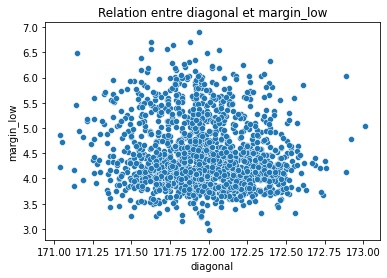

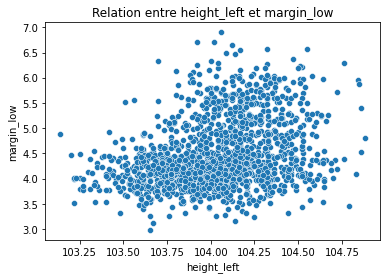

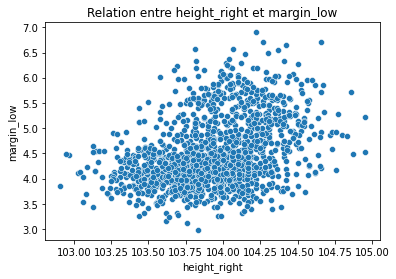

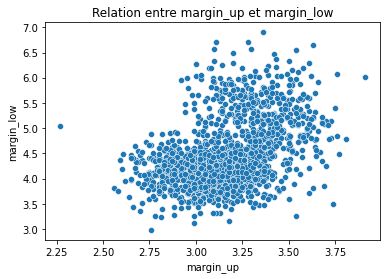

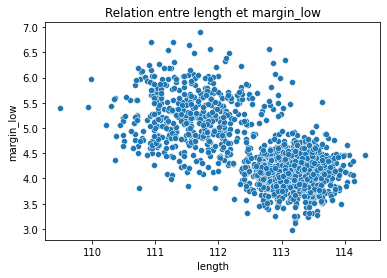

In [201]:
# Analyse des relations entre les variables 

predictive_variables = ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']

# Création de graphiques de dispersion pour chaque variable prédictive
for variable in predictive_variables:
    sns.scatterplot(x=df[variable], y=df['margin_low'])
    plt.title(f'Relation entre {variable} et margin_low')
    plt.xlabel(variable)
    plt.ylabel('margin_low')
    plt.show()

(analyse des scatter plots)

La régression linéaire multiple est performante si la variable dépendante est fortement corrélés avec d'autres variables indépendantes. 
Examinons les corrélations entre nos différentes variables :

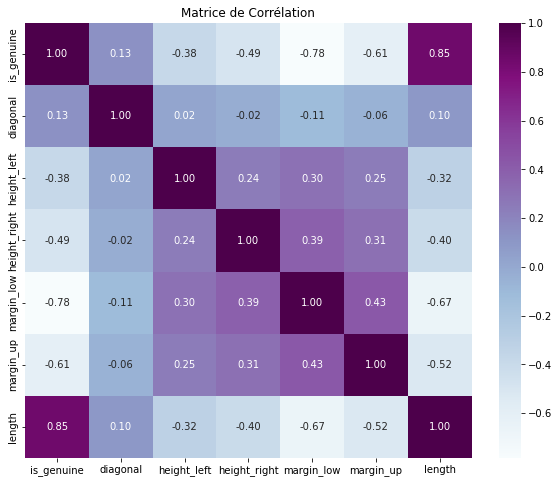

In [202]:
# On visualise la matrice de corrélations :

matrice_corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matrice_corr, annot=True, fmt=".2f", cmap='BuPu')
plt.title("Matrice de Corrélation")
plt.show()

La variable "margin_low" semble corrélée positivement avec les variables "height_right", "height_left", "margin_up".</br>
Elle est aussi corrélée négativement avec les variables "length" et "is_genuine".</br>
Elle est très peu corélée à la variable "diagonal".</br>

***Globalement les corrélations ne sont pas faibles, ce qui est un bon signe pour l'imputation par régression.***
</br>
</br>
On calcule ensuite le Facteur d'Inflation de la Variance (VIF) qui est une mesure qui quantifie le degré de multicollinéarité dans un modèle de régression linéaire. </br>
Un VIF supérieur à 5 indique que les variables indépendantes sont fortement corrélées et peuvent donc ne pas fournir des estimations indépendantes.

In [203]:
X = df.drop(['margin_low','is_genuine'], axis=1)
X = sm.add_constant(X)

# Calcul du VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

        feature            VIF
0         const  591443.076346
1      diagonal       1.012790
2   height_left       1.145295
3  height_right       1.229263
4     margin_up       1.403517
5        length       1.574765


Ici, aucunes variables n'a un VIF > 5 

***Application du modèle aux données :***

In [204]:
# création d'un df sans les individus avec NaN dans margin_low (modèle d'apprentissage)

df_no_nan = df.dropna(subset=['margin_low'])

In [205]:
# isoler les NaN dans une variable (modèle de test)

df_nan = df[df['margin_low'].isna()]

In [206]:
# définition des variable X (regresseurs) et Y (variable à prédire)

X_train = df_no_nan.drop(columns=['margin_low'])  # Toutes les autres colonnes sont les features
y_train = df_no_nan['margin_low']

In [207]:
# Application du modèle aux données

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

***Analyse des résultats de la régression linéaire :***

In [208]:
reg_multi = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_no_nan).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Fri, 23 Feb 2024   Prob (F-statistic):          2.60e-202
Time:                        07:28:10   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       22.9948      9.656      2.382   

Nous allons ici réaliser les tests à un niveau $\alpha=5$% :

In [209]:
alpha = 0.05

Récupérons $n$, le nombre d'individus de l'échantillon, et $p$, le nombre de variables.

In [210]:
n = df_no_nan.shape[0]
p = 6

In [211]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

- Calculez les leviers : 

On peut calculer les leviers comme ceci, en sachant que le seuil des leviers est de $2∗\frac{p}{n}$.

In [212]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

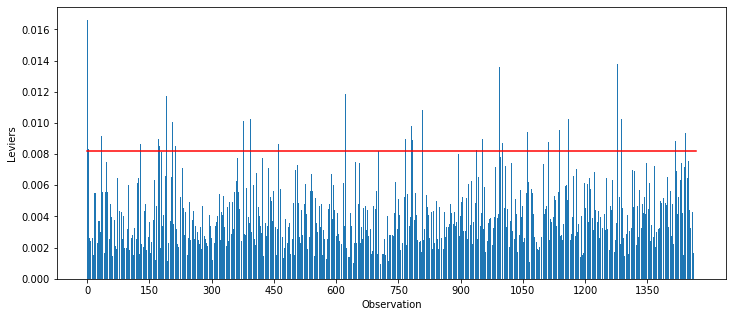

In [213]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1467, step=150))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1467], [seuil_levier, seuil_levier], color='r')

plt.savefig(r"viz\leviers nan")

plt.show()

In [214]:
analyses.loc[analyses['levier'] > seuil_levier, :]

,obs,levier
0,1,0.016606
2,3,0.008298
34,35,0.009156
52,53,0.013635
56,57,0.009087
...,...,...
1416,1417,0.008521
1417,1418,0.008870
1428,1429,0.008390
1441,1442,0.009325


- Calcul des résidus studentisés :

Si l'on souhaite maintenant calculer les résidus studentisés, nous écrivons ceci, sachant que le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté :

In [215]:
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

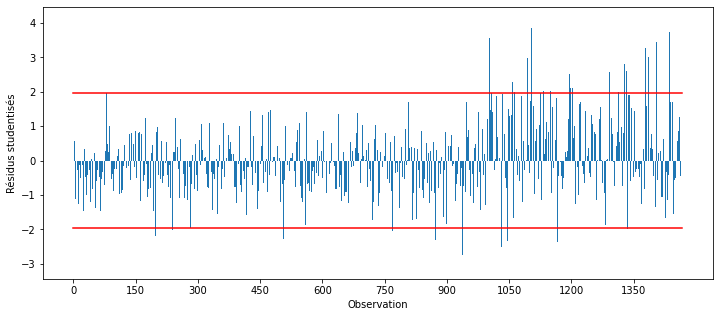

In [216]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1467, step=150))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1467], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1467], [-seuil_rstudent, -seuil_rstudent], color='r')

plt.savefig(r"viz\résidus studentisés")

plt.show()

- Déterminez la distance de Cook

Pour trouver la distance de Cook, nous exécutons ceci :

In [217]:
influence = reg_multi.get_influence().summary_frame()

In [218]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

On peut détecter les observations influentes comme ceci :

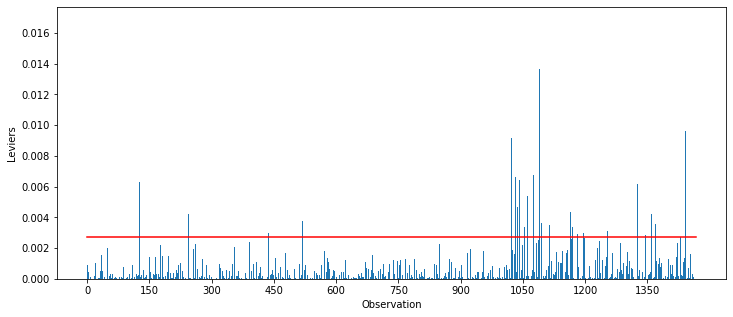

In [219]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1467, step=150))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1467], [seuil_dcook, seuil_dcook], color='r')

plt.savefig(r"viz\distance de cook résidus")


plt.show()

On ne retire des points qu'après avoir vérifié qu'ils sont effectivement atypiques, voire aberrants, au vu du modèle estimé.

***Analyse des résidus***

comment savoir qu'ils sont bien abberants ?

In [220]:
flag_residus = analyses.loc[analyses['dcooks'] > seuil_dcook, :]
flag_residus.shape

(79, 4)

In [221]:
index_residus = flag_residus.index
residus = df_no_nan.loc[index_residus]

In [222]:
residus.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
52,True,171.64,104.18,103.78,3.49,3.74,113.94
80,True,171.89,103.42,103.35,4.92,3.02,113.20
125,True,171.50,104.03,103.97,3.26,3.54,113.24


In [223]:
#perte d'infos en % si retrait 

prop_residus = (residus.shape[0] / df.shape[0]) * 100

print(f"{round(prop_residus, 2)}%")

5.27%


La proportion de résidus représente 5.27% du jeu de données total

In [224]:
# retrait des résidus

df_cleaned = df_no_nan.drop(index=index_residus)
# df_cleaned.reset_index(drop=True, inplace=True)

In [225]:
df_cleaned.shape

(1384, 7)

In [226]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1384 non-null   bool   
 1   diagonal      1384 non-null   float64
 2   height_left   1384 non-null   float64
 3   height_right  1384 non-null   float64
 4   margin_low    1384 non-null   float64
 5   margin_up     1384 non-null   float64
 6   length        1384 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 77.0 KB


On applique le modele de regression sur notre df sans les résidus influents

In [227]:
reg_multi_clean = smf.ols('margin_low~diagonal+height_left+height_right+margin_up+length', data=df_cleaned).fit()
print(reg_multi_clean.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     322.5
Date:                Fri, 23 Feb 2024   Prob (F-statistic):          7.46e-229
Time:                        07:28:37   Log-Likelihood:                -739.33
No. Observations:                1384   AIC:                             1491.
Df Residuals:                    1378   BIC:                             1522.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       24.4256      8.631      2.830   

On remarque qu'après retrait des residus influents et application du modèle, on obtient : 
- un R² de 0.539 
- une AIC de 1491.

Le modèle est maintenant plus performant

In [228]:
n = df_cleaned.shape[0]
p = 6

In [229]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

In [230]:
analyses['levier'] = reg_multi_clean.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

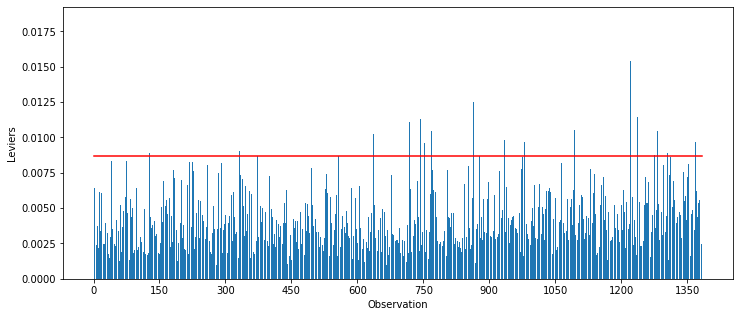

In [231]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1384, step=150))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1384], [seuil_levier, seuil_levier], color='r')

plt.savefig(r"viz\leviers nan cleaned 1")

plt.show()

In [232]:
analyses['rstudent'] = reg_multi_clean.get_influence().resid_studentized_internal
seuil_rstudent = t.ppf(1-alpha/2,n-p-1)

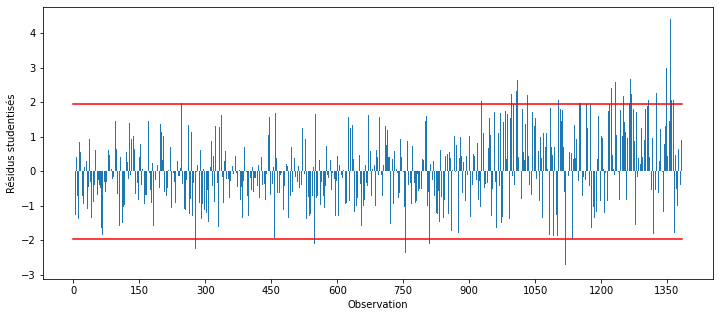

In [233]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, 1384, step=150))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, 1384], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, 1384], [-seuil_rstudent, -seuil_rstudent], color='r')

plt.savefig(r"viz\résidus studentisés cleaned 1")

plt.show()

In [234]:
influence = reg_multi_clean.get_influence().summary_frame()

In [235]:
analyses['dcooks'] = influence['cooks_d']
seuil_dcook = 4/(n-p)

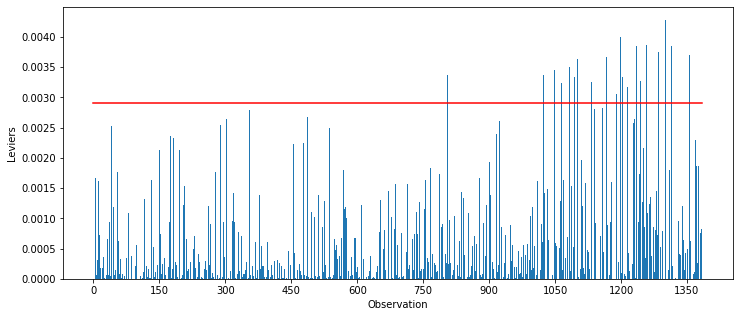

In [236]:
plt.figure(figsize=(12,5))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, 1384, step=150))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1384], [seuil_dcook, seuil_dcook], color='r')

plt.savefig(r"viz\distance de cook résidus cleaned 1")

In [237]:
df_cleaned['remove_flag'] = analyses['dcooks'] > seuil_dcook

df_cleaned[df_cleaned['remove_flag']==True].max()

is_genuine        True
diagonal        172.74
height_left     104.53
height_right    104.56
margin_low         6.2
margin_up         3.66
length          114.32
remove_flag       True
dtype: object

In [238]:
df_cleaned.drop(columns='remove_flag', inplace=True)

- Vérifier la colinéarité des variables

Une autre chose à vérifier est l'éventuelle colinéarité approchée des variables :

In [239]:
variables = reg_multi_clean.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0169306037841417,
 1.1280602961722561,
 1.2341667326096388,
 1.4123387311616173,
 1.5940221634498568]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

- Testez l’homoscédasticité

On peut également tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :

In [240]:
_, pval, __, f_pval = statsmodels.stats.diagnostic.het_breuschpagan(reg_multi_clean.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 8.763044082846886e-10


La p-valeur ici n'est pas inférieure à $5$%, on ne rejette pas l'hypothèse $H0$ selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité).

- Testez la normalité des résidus

Si l'on veut tester la normalité des résidus, on peut faire un test de Shapiro-Wilk.

In [241]:
shapiro(reg_multi_clean.resid)

ShapiroResult(statistic=0.9929782748222351, pvalue=3.800486865657149e-06)

Ici, l'hypothèse de normalité n'est pas remise en cause (p-value < 0.05).

***Prediction des 37 valeurs manquantes :***

In [242]:
# Préparation des données pour lesquelles 'margin_low' est NaN pour la prédiction

X_missing = df_nan[df_nan['margin_low'].isnull()].drop(columns=['margin_low'])

In [243]:
# Prédiction des valeurs manquantes
predicted_margin_low = model.predict(X_missing)

In [244]:
# on créé une Series avec les valeurs prédites, avec le meme index que notre df d'origine
predicted_margin_low_series = pd.Series(predicted_margin_low, index=X_missing.index)

In [245]:
# Remplissage des valeurs manquantes avec les prédictions
df_nan.loc[df_nan['margin_low'].isnull(), 'margin_low'] = predicted_margin_low_series

In [246]:
df_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 72 to 1438
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    37 non-null     bool   
 1   diagonal      37 non-null     float64
 2   height_left   37 non-null     float64
 3   height_right  37 non-null     float64
 4   margin_low    37 non-null     float64
 5   margin_up     37 non-null     float64
 6   length        37 non-null     float64
dtypes: bool(1), float64(6)
memory usage: 2.1 KB


In [247]:
df_cleaned = pd.concat([df_cleaned, df_nan])
# Triez le DataFrame concaténé par index pour remettre les lignes à leur place d'origine
# df_cleaned = df_cleaned.reset_index(drop=True)

In [248]:
df_cleaned

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.520000,2.89,112.83
1,True,171.46,103.36,103.66,3.770000,2.99,113.09
2,True,172.69,104.48,103.50,4.400000,2.94,113.16
3,True,171.36,103.91,103.94,3.620000,3.01,113.51
4,True,171.73,104.28,103.46,4.040000,3.48,112.54
...,...,...,...,...,...,...,...
1303,False,172.17,104.49,103.76,5.302069,2.93,111.21
1315,False,172.08,104.15,104.17,5.200358,3.40,112.29
1347,False,171.72,104.46,104.12,5.175468,3.61,110.31
1435,False,172.66,104.33,104.41,5.173450,3.56,111.47


### Comparaison des deux méthodes d'imputation

Nous n'avons pas de valeurs de références pour apprécier l'ajustement et la précision de l'imputation des valeurs manquantes. 
Nous allons donc appliquer les deux méthodes sur un dataset sans valeurs manquantes, afin de prédire une des variables numériques (magin_up car + forte corrélation) et comparer les résultats de la prédiction avec leurs valeurs réelles. Le modèle qui prédira les valeurs les plus proches des valeurs d'origine sera retenu.

In [249]:
df_knn.loc[index_nan].head(5)

,diagonal,height_left,height_right,margin_low,margin_up,length
72,171.94,103.89,103.45,4.046,3.25,112.79
99,171.93,104.07,104.18,4.278,3.14,113.08
151,172.07,103.80,104.38,4.214,3.02,112.93
197,171.45,103.66,103.80,4.106,3.62,113.27
241,171.83,104.14,104.06,5.348,3.02,112.36


In [250]:
# filtre = ~index_nan.isin([1435, 1438])
# index_filtrés = index_nan[filtre]

df_cleaned.loc[index_nan].head(5)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.064954,3.25,112.79
99,True,171.93,104.07,104.18,4.111990,3.14,113.08
151,True,172.07,103.80,104.38,4.134003,3.02,112.93
197,True,171.45,103.66,103.80,3.993571,3.62,113.27
241,True,171.83,104.14,104.06,4.140399,3.02,112.36


Les valeurs varient en fonction des deux méthodes, + ou - selon les individus

In [296]:
# préparation du dataset d'entrainement

n_rows = len(df_no_nan)

# Calculate the number of rows to include in the sample
n_sample = int(n_rows * 0.2)

# Generate a list of random indices
random_indices = np.random.choice(n_rows, size=n_sample, replace=False)

# Select the rows of the dataset corresponding to the random indices
y_train = df_no_nan.iloc[random_indices]


X_train = df_no_nan.iloc[~random_indices]


In [299]:
X_train

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
367,True,171.73,104.17,104.02,3.64,2.64,112.72
1219,False,172.23,103.81,104.13,5.24,3.17,110.91
743,True,172.30,104.58,104.17,4.36,3.33,112.98
1141,False,171.98,103.81,104.35,4.57,3.52,111.73
998,True,171.44,103.96,103.92,3.68,2.89,113.21
...,...,...,...,...,...,...,...
1063,False,171.44,103.99,104.04,4.81,3.49,111.74
888,True,172.15,104.28,103.67,4.28,3.24,113.35
832,True,171.80,104.30,103.58,4.75,3.00,112.94
992,True,171.79,103.69,103.68,3.65,2.77,112.78


In [ ]:
from sklearn.model_selection import train_test_split

# Assume `df` is your dataframe with 1500 rows

# Split the dataframe into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['target_column']),  # features
    df['target_column'],  # target
    test_size=0.2,  # 20% testing set
    random_state=42  # for reproducibility
)
888888

In [295]:
# knn

df_no_nan

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [ ]:
# reg lin



In [ ]:
df_cleaned = df_cleaned.reset_index(drop=True)

reg lin prediction d'une colonne et comparer avec origine + knn pred une colonne et comparer avec origine

### Doublons

In [251]:
df_cleaned.duplicated().sum()

0

In [252]:
# Affichage des doublons

doublons = df_cleaned[df_cleaned.duplicated(subset=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length'], keep=False)]
display(doublons)

# Calculer le nombre de doublons
nb_doublons = df_cleaned.duplicated(subset=['is_genuine', 'diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']).sum()
print(f"Nombre de variables avec doublons: {nb_doublons}")

# Calculer la proportion de doublons
prop_doublons = round((nb_doublons / len(df_cleaned)) * 100, 2)
print(f"Proportion de variables avec doublons: {prop_doublons}%")

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length


Nombre de variables avec doublons: 0
Proportion de variables avec doublons: 0.0%


## 3. EDA

In [253]:
# Création d'un df avec les valeurs numériques, et un autre normalisé

df_num = df_cleaned.select_dtypes(float)

sc = StandardScaler()
df_norm = pd.DataFrame(sc.fit_transform(df_num), columns=df_num.columns, index=df_num.index)

In [254]:
palette_gen = {True: "#00BFFF", False: "#A901DB"}

### Analyse univariée

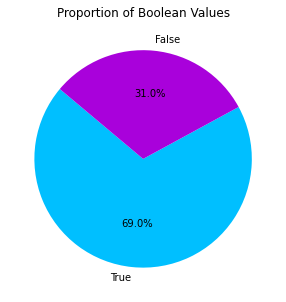

In [255]:
values_gen = df_cleaned['is_genuine'].value_counts()

colors = [palette_gen[value] for value in values_gen.index]
plt.figure(facecolor='white', figsize=(5,5)) 
plt.pie(values_gen, labels=values_gen.index.map({True: 'True', False: 'False'}), autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Proportion of Boolean Values')
plt.show()

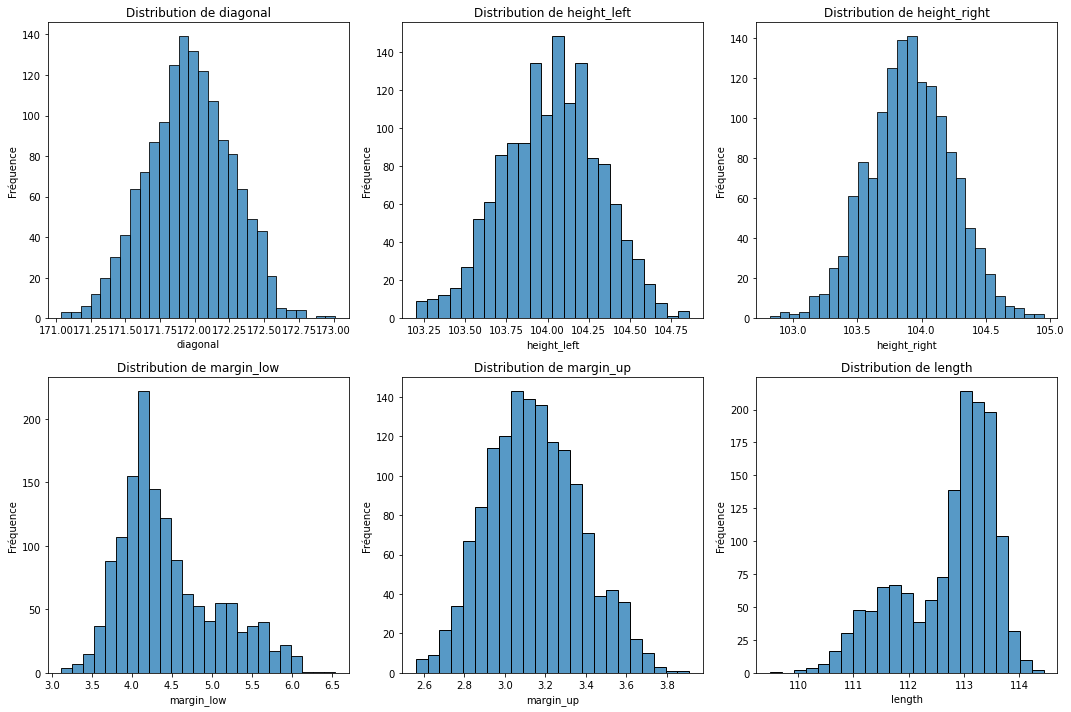

In [256]:
n_cols = 3  

# Le nombre de lignes doit être basé sur le nombre de colonnes du DataFrame df_num
n_rows = (len(df_num.columns) + n_cols - 1) // n_cols  

# Créer une grille de subplots avec la taille correcte
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Parcourir chaque colonne numérique et créer un subplot
for i, column in enumerate(df_num.columns):
    ax = axes[i // n_cols, i % n_cols]
    sns.histplot(df_num[column], kde=False, ax=ax)
    ax.set_title(f'Distribution de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Fréquence')

# Masquer les axes vides s'il y en a
for j in range(i + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].set_visible(False)

# Ajuster le layout pour éviter le chevauchement
plt.tight_layout()
plt.show()

<AxesSubplot:>

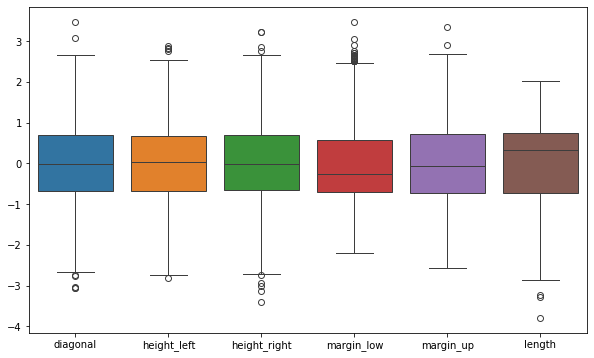

In [257]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_norm)

### Traitement des outliers

a faire avant imputation 

### Analyse bivariée

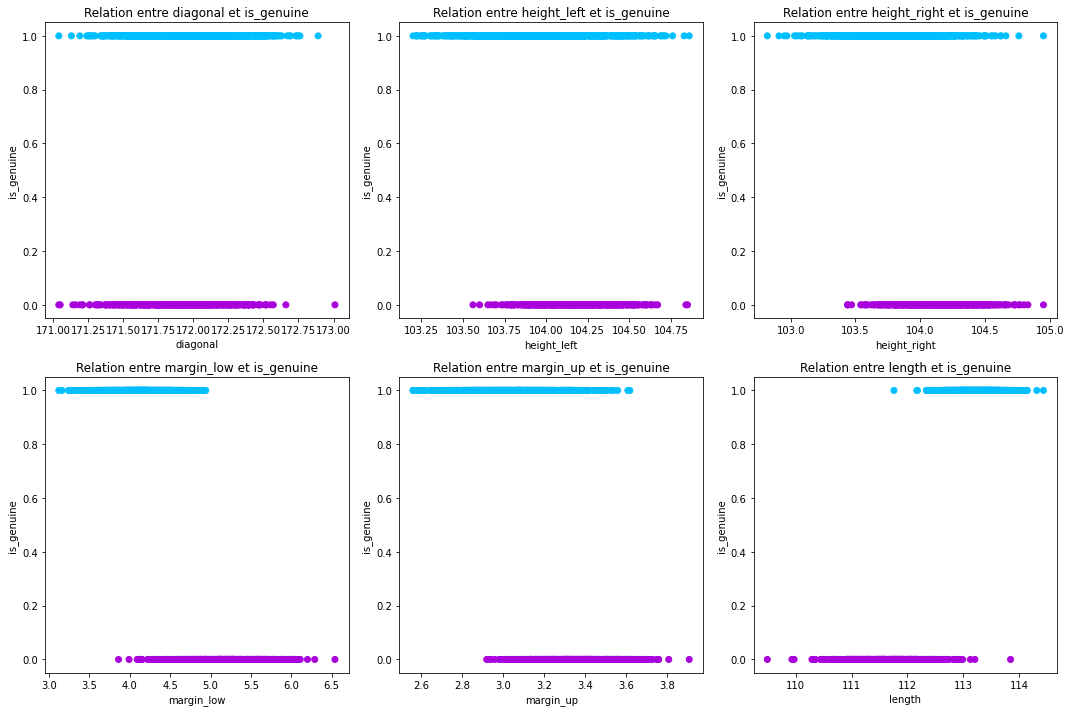

In [258]:
col = df_cleaned.drop(columns='is_genuine')

n_cols = 3
n_rows = (len(col.columns) + n_cols - 1) // n_cols

# Créer une grille de subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

i = 0  # Initialiser le compteur
for var in col.columns:
    ax = axes[i // n_cols, i % n_cols]  # Trouver la position correcte dans la grille
    
    # Créer une liste de couleurs pour chaque point
    colors = [palette_gen[bool(val)] for val in df_cleaned['is_genuine']]
    
    # Utiliser la liste de couleurs pour la coloration des points
    ax.scatter(y=df_cleaned['is_genuine'], x=df_cleaned[var], c=colors)
    
    ax.set_title(f'Relation entre {var} et is_genuine')
    ax.set_xlabel(var)
    ax.set_ylabel('is_genuine')
    i += 1  # Incrémenter le compteur après chaque itération

# Masquer les axes vides s'il y en a
for j in range(i, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].set_visible(False)

# Ajuster le layout pour éviter le chevauchement
plt.tight_layout()
plt.show()

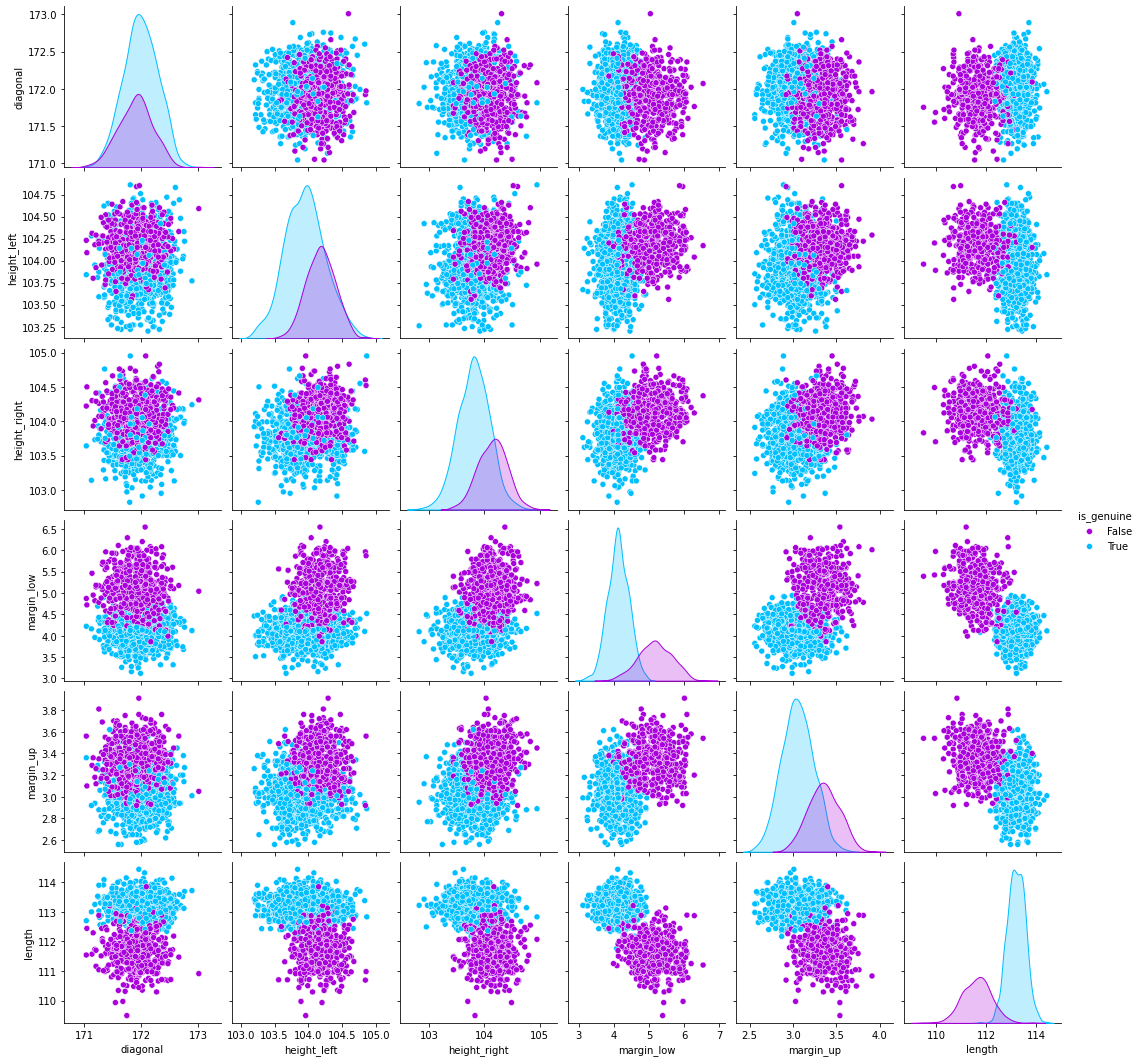

In [259]:
sns.pairplot(df_cleaned, hue='is_genuine', palette=palette_gen)

# sns.pairplot(df_num)

Plusieurs infos sont à relever de ce pairplot :

- On distingue les deux classes sur les différents nuages de points : les valeurs sont bien représentés pour certaines variables (...)
-
-
-

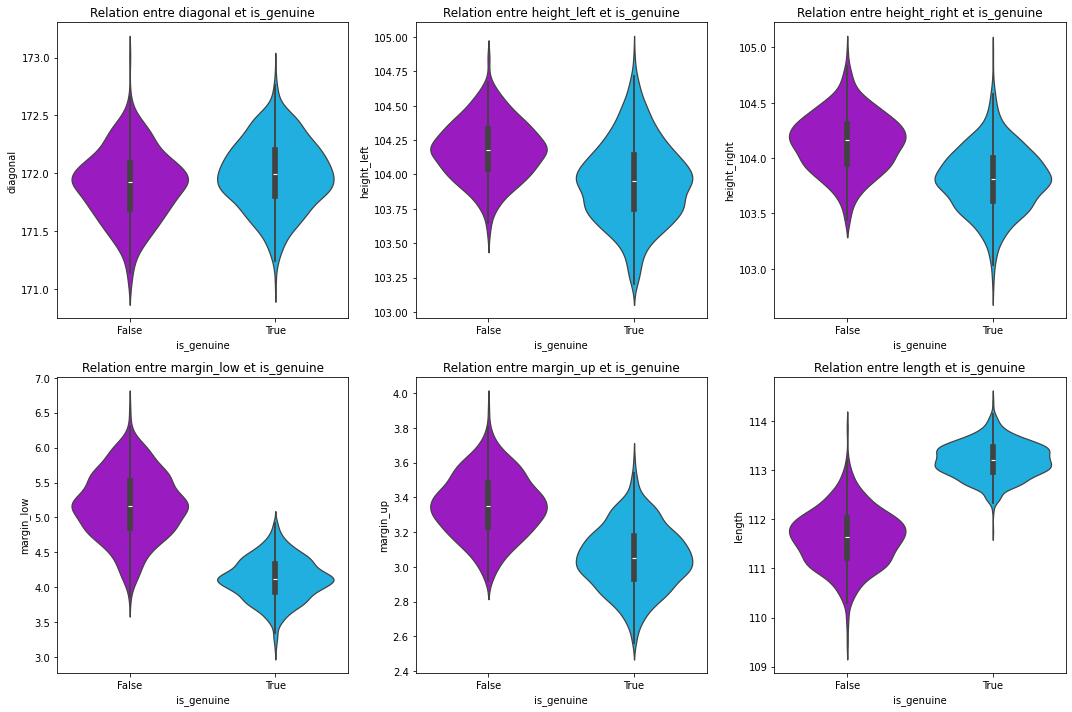

In [260]:
palette_2 = {'True': "#00BFFF", 'False': "#A901DB"}

# Calcul du nombre de lignes et de colonnes pour les subplots
n_cols = 3  # Définir le nombre de colonnes dans la grille d'affichage
n_rows = (len(df_num.columns) + n_cols - 1) // n_cols  # Calculer le nombre de lignes nécessaire

# Créer une grille de subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

# Parcourir chaque colonne numérique et créer un subplot pour le violinplot
for i, variable in enumerate(df_num.columns):
    ax = axes[i // n_cols, i % n_cols]  # Trouver la position correcte dans la grille
    sns.violinplot(y=df_num[variable], x=df_cleaned['is_genuine'], palette=palette_2, ax=ax)
    ax.set_title(f'Relation entre {variable} et is_genuine')
    ax.set_ylabel(variable)
    ax.set_xlabel('is_genuine')

# Masquer les axes vides s'il y en a
for j in range(i + 1, n_rows * n_cols):
    axes[j // n_cols, j % n_cols].set_visible(False)

# Ajuster le layout pour éviter le chevauchement
plt.tight_layout()
plt.show()

In [261]:
# cross tab

for i in df_cleaned.drop(columns=['is_genuine']).columns:

    binned_column = pd.cut(df_cleaned[i], bins=3)
    
    # Créer un crosstab entre 'is_genuine' et la colonne discrétisée
    crosstab = pd.crosstab(df_cleaned['is_genuine'], binned_column)
    
    # Afficher le nom de la colonne et le crosstab correspondant
    print(f"Crosstab for {i}:")
    print(crosstab)
    print("\n")

Crosstab for diagonal:
diagonal    (171.038, 171.697]  (171.697, 172.353]  (172.353, 173.01]
is_genuine                                                           
False                      111                 297                 32
True                       166                 698                117


Crosstab for height_left:
height_left  (103.198, 103.753]  (103.753, 104.307]  (104.307, 104.86]
is_genuine                                                            
False                         8                 307                125
True                        265                 597                119


Crosstab for height_right:
height_right  (102.818, 103.53]  (103.53, 104.24]  (104.24, 104.95]
is_genuine                                                         
False                         4               279               157
True                        171               754                56


Crosstab for margin_low:
margin_low  (3.117, 4.26]  (4.26, 5.4]  (5.4, 6.54]
is_ge

In [262]:
# test de kuskal-wallis pour comprendre la relation entre l'authenticité d'un billet (variable is_genuine) et l'ensemble de nos variables quantitatives 

columns_num = df_num.columns

# Initialisation d'un DataFrame pour les résultats avec les noms de colonnes corrects
results = pd.DataFrame(columns=["variable", "Kruskal-Wallis", "P_value"])

# Boucle sur chaque variable numérique et exécution du test de Kruskal-Wallis
for var in columns_num:
    # Regrouper les données selon la catégorie 'is_genuine'
    groups = [group[var].dropna().values for name, group in df_cleaned.groupby('is_genuine')]
    # Effectuer le test de Kruskal-Wallis
    kruskal_test = kruskal(*groups)
    # Ajouter les résultats au DataFrame
    new_row = pd.DataFrame({"variable": [var], "Kruskal-Wallis": [kruskal_test.statistic], "P_value": [kruskal_test.pvalue]})
    results = pd.concat([results, new_row], ignore_index=True)

# Trier les résultats par la colonne 'P_value' en ordre croissant
results_sorted = results.sort_values(by="P_value", ascending=True)

# Afficher les résultats
print(results_sorted)

       variable  Kruskal-Wallis        P_value
5        length      872.628906  8.751240e-192
3    margin_low      802.133596  1.854299e-176
4     margin_up      523.212387  8.465422e-116
2  height_right      340.966882   3.929179e-76
1   height_left      206.816957   6.797359e-47
0      diagonal       23.546150   1.219532e-06


Toutes les variables ont une p_value < 0.05 : elles sont donc toutes significative

Les variables length, margin_low et margin_up sont les plus significatives pour déterminer l'authenticité d'un billet.

# Modèle de prédiction

## Régression logistique

In [263]:
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=df_cleaned, family=sm.families.Binomial()).fit()

print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1421
Model:                                                   GLM   Df Residuals:                     1414
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -38.647
Date:                                       Fri, 23 Feb 2024   Deviance:                       77.293
Time:                                               07:29:41   Pearson chi2:                 2.84e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.6937
Covariance Type:                                   nonrobust                      

In [264]:
# définition des variable explicatives et de la variable d'intérêt 
X = df_cleaned.drop(columns=['is_genuine', 'diagonal', 'height_left'])
y = df_cleaned['is_genuine']

In [265]:
# Ajout d'une contsante pour l'interception
X = sm.add_constant(X)

In [266]:
#split du dataset en ensemble d'apprentissage et de test 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

La fonction train_test_split divise les données en un ensemble d'entraînement (80% des données) et un ensemble de test (20% des données), ce qui est défini par test_size=0.2. 
L'argument random_state=42 garantit que la séparation est reproductible; les mêmes données seront divisées de la même manière à chaque exécution.

In [267]:
# création du modèle 
logit_model = sm.Logit(y_train, X_train)

In [268]:
# ajustement du modèle aux données
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.027988
         Iterations 13


In [269]:
print(result.summary())

                           Logit Regression Results                           
Dep. Variable:             is_genuine   No. Observations:                 1136
Model:                          Logit   Df Residuals:                     1131
Method:                           MLE   Df Model:                            4
Date:                Fri, 23 Feb 2024   Pseudo R-squ.:                  0.9546
Time:                        07:29:41   Log-Likelihood:                -31.794
converged:                       True   LL-Null:                       -699.93
Covariance Type:            nonrobust   LLR p-value:                4.530e-288
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         -246.8215    159.365     -1.549      0.121    -559.171      65.528
height_right    -3.6554      1.298     -2.816      0.005      -6.199      -1.112
margin_low      -5.9177      1.151     -5.14

(0.0, 1.05)

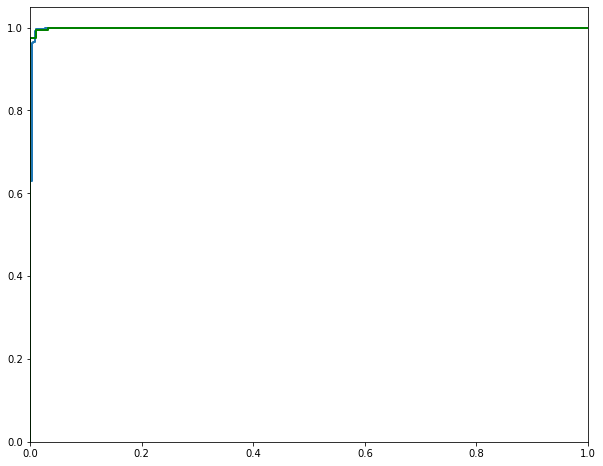

In [270]:
# obtenir les prédictions du modèle sur le dataset de train et de test
y_train_pred = result.predict(X_train)
y_test_pred = result.predict(X_test)

# calcul des courbes ROC et AUC
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
roc_auc_train = auc(fpr_train, tpr_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
roc_auc_test = auc(fpr_test, tpr_test)

# tracage des courbes
plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train, lw=2, label='ROC curve train')
plt.plot(fpr_test, tpr_test, color='green', lw=2, label='ROC curve test')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# ACP

In [271]:
#dimension
print(df_cleaned.shape) 

#nombre d'observations
n = df_cleaned.shape[0]

#nombre de variables
p = df_cleaned.shape[1]

df_cleaned.head(5)

(1421, 7)


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [272]:
# On applique l'ACP au variables quantitaves continues

df_num_clean = df_cleaned.drop(columns='is_genuine')

sc = StandardScaler()
df_std = sc.fit_transform(df_num_clean)

df_std

array([[-0.50496972,  2.86925157,  3.23069446,  0.1229049 , -1.12108124,
         0.13365408],
       [-1.6674706 , -2.25939606, -0.78557754, -1.11674795, -0.68300715,
         0.43946838],
       [ 2.41788963,  1.56999417, -1.2837198 , -0.07543955, -0.9020442 ,
         0.521803  ],
       ...,
       [-0.80389852,  1.5016122 ,  0.64658147,  1.20630826,  2.03305224,
        -2.83039224],
       [ 2.3182467 ,  1.05712941,  1.54946432,  1.20297386,  1.81401519,
        -1.46598997],
       [-0.20604092,  0.88617449,  1.17585763,  1.32412942,  0.41217809,
        -1.44246579]])

In [273]:
#verif des moyennes
print(np.mean(df_std,axis=0))

[ 3.42020571e-14 -3.02418189e-14 -8.26049683e-15  2.80016842e-16
 -3.20019248e-16  9.48057021e-15]


In [274]:
#verif de écart types => ils sont unitaires 
print(np.std(df_std,axis=0,ddof=0))

[1. 1. 1. 1. 1. 1.]


In [275]:
#instance 
n_comp = 6

pca = PCA(n_components=n_comp)
pca.fit(df_std)
print('Nb de composantes calculées : ', pca.n_components_)

Nb de composantes calculées :  6


In [276]:
#on affiche la variance expliqué

print(pca.explained_variance_)

[2.63761574 1.02867305 0.79019267 0.70642226 0.55882839 0.28249325]


In [277]:
#et la valeur corrigée

eigval = (n-1)/n*pca.explained_variance_
print(eigval)

[2.63575957 1.02794914 0.78963659 0.70592513 0.55843512 0.28229445]


In [278]:
#puis sous forme de %

print(pca.explained_variance_ratio_)

[0.43929326 0.17132486 0.1316061  0.11765419 0.09307252 0.04704907]


In [279]:
# % de variance expliqué pour chaque variable

eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(6)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
eig

,Dimension,Variance expliquée,% variance expliquée,% cum. var. expliquée
0,Dim1,2.637616,44.0,44.0
1,Dim2,1.028673,17.0,61.0
2,Dim3,0.790193,13.0,74.0
3,Dim4,0.706422,12.0,86.0
4,Dim5,0.558828,9.0,95.0
5,Dim6,0.282493,5.0,100.0


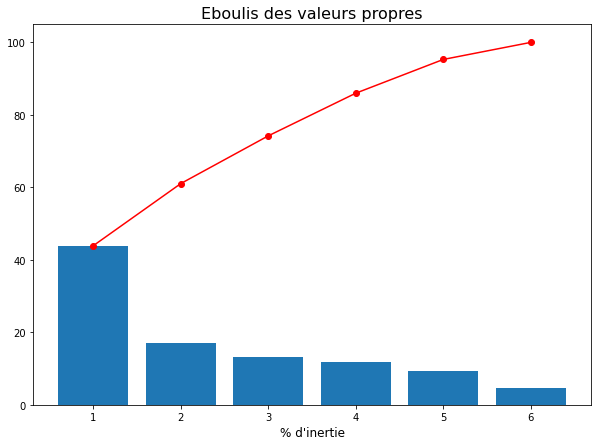

In [280]:
#scree plot avec méthode du coude pour déterminer le nombre de variable optimal

def display_scree_plot(pca):
    scree=pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red", marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.xlabel("% d'inertie", fontsize=12)
    plt.title('Eboulis des valeurs propres', fontsize=16)
    # plt.savefig(r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\éboulis des valeurs propres.png")
    plt.show(block=False)

plt.figure(figsize=(10,7))

display_scree_plot(pca)

In [281]:
#on applique le modèle sur 2 composantes principales car l'objectif est de visualiser

pca = PCA(n_components=2).fit(df_std)
xk_projected = pca.transform(df_std)

In [282]:
# Transformation en DataFrame pandas

df_pca = pd.DataFrame({
    "Dim1" : xk_projected[:,0], 
    "Dim2" : xk_projected[:,1],
})

df_pca.head()

,Dim1,Dim2
0,1.715057,0.898496
1,-1.996216,-2.306660
2,-0.913572,2.711021
3,-1.385046,-1.803975
4,0.194076,-0.517122


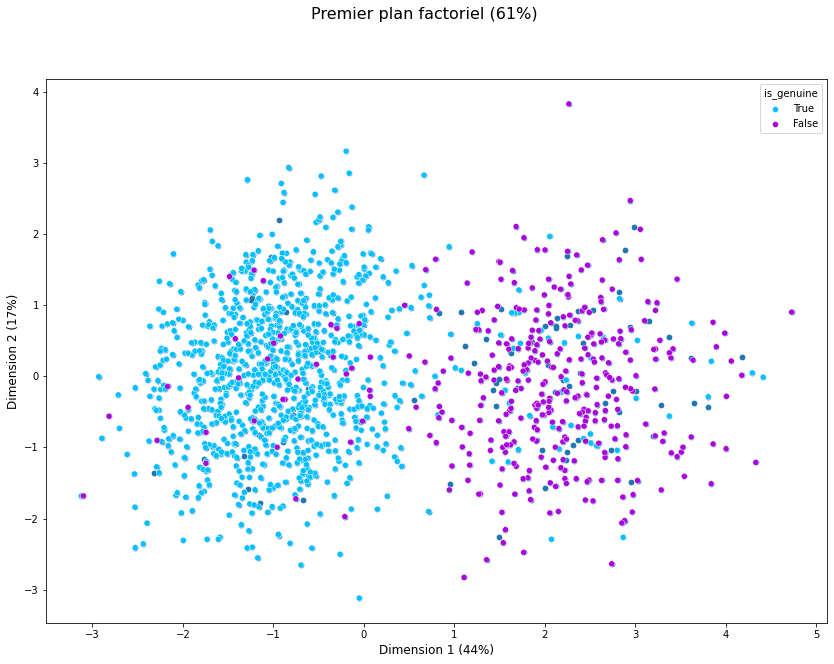

In [283]:
#visualisation du plan factoriel 

fig, ax = plt.subplots(figsize=(14, 10))
df_pca.plot.scatter("Dim1", "Dim2", ax = ax) 

scatter = df_pca.plot.scatter("Dim1", "Dim2", ax=ax)

plt.xlabel("Dimension 1 (44%)", fontsize=12) 
plt.ylabel("Dimension 2 (17%)", fontsize=12)
plt.suptitle("Premier plan factoriel (61%)", fontsize=16)

#associer une couleur par continent
sns.scatterplot(data=df_pca, x="Dim1", y="Dim2", hue=df_cleaned['is_genuine'], palette=palette_gen, ax=scatter)

# plt.savefig(
    # r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\premier plan factoriel avec continents.png",
# )

plt.show()

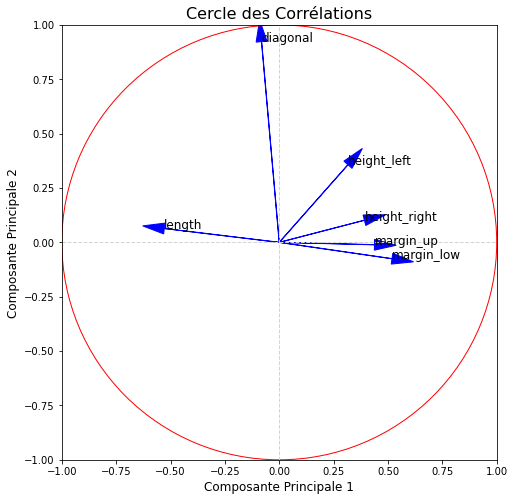

In [284]:
# Création d'un cercle des corrélations

variable_loadings = pca.components_[:2, :]

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

for i, (comp1, comp2) in enumerate(zip(variable_loadings[0, :], variable_loadings[1, :])):
    ax.arrow(0, 0, comp1, comp2, head_width=0.05, head_length=0.1, fc='blue', ec='blue')
    ax.text(comp1, comp2, df_num_clean.columns[i], fontsize=12)

circle = plt.Circle((0, 0), 1, fill=False, color='red')
ax.add_artist(circle)

ax.axhline(0, color='lightgray', linestyle='--', linewidth=1)
ax.axvline(0, color='lightgray', linestyle='--', linewidth=1)

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel("Composante Principale 1", fontsize=12)
ax.set_ylabel("Composante Principale 2", fontsize=12)
ax.set_title("Cercle des Corrélations", fontsize=16)

# plt.savefig(
#     r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\cercle corr.png",
# )

plt.show()

In [285]:
#verif des corrélations des variables en calculant le coeff de correlation (Dispo + importations)

corr = df_cleaned["is_genuine"].corr(df_cleaned["length"], method='spearman')

corr

0.7839179797277556

## K-Means

In [286]:
#instance du modèle

cluster_range = [2,3,4,5,6,7,8]

inertie = []

for c in cluster_range:
    kmeans=KMeans(init='k-means++', n_clusters=c).fit(df_pca)
    inertie.append(kmeans.inertia_)

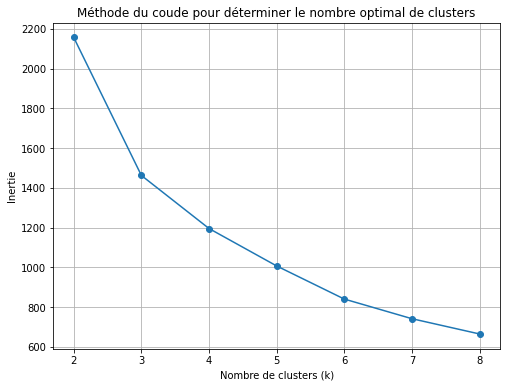

In [287]:
#représentation avec méthode du coude et choix du nb de clusters

plt.figure(figsize=(8,6))
plt.plot(cluster_range, inertie, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.grid(True)

# plt.savefig(
#     r"C:\Users\derou\OneDrive\Bureau\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\coude.png",
# )

plt.show()

In [288]:
# il y aura 3 clusters. Affichage de la table avec la nouvelle colonne labels

kmeans = KMeans(n_clusters=2, random_state=1).fit(df_pca)
labels = kmeans.labels_

dfa_pca_kmeans = pd.DataFrame(data=df_pca)
dfa_pca_kmeans['labels_kmeans']=labels

dfa_pca_kmeans

,Dim1,Dim2,labels_kmeans
0,1.715057,0.898496,1
1,-1.996216,-2.306660,0
2,-0.913572,2.711021,0
3,-1.385046,-1.803975,0
4,0.194076,-0.517122,0
...,...,...,...
1416,1.521615,0.953241,1
1417,1.821212,0.463128,1
1418,3.805389,-0.433520,1
1419,2.945227,2.471608,1


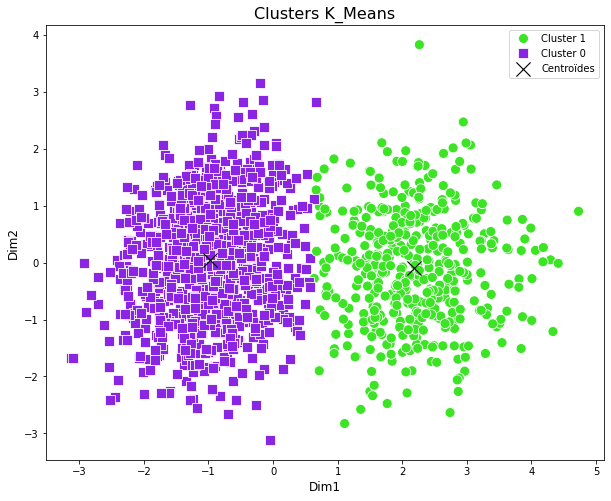

In [289]:
#représentation des clusters et des centroides sur nuage de points

cluster_data = dfa_pca_kmeans.copy()
cluster_data['Cluster'] = cluster_data['labels_kmeans'].apply(lambda x: f'Cluster {x}')
 
cluster_colors = ['#3CE425', '#8A25E4', '#25ADE4', '#E38AAE']

plt.figure(figsize=(10, 8))
sns.scatterplot(data=cluster_data, x='Dim1', y='Dim2', hue='Cluster', palette=cluster_colors, s=100, style='Cluster', markers=['o', 's', 'D', 'p'])
sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], color='black', marker='x', s=200, label='Centroïdes')

plt.title('Clusters K_Means', fontsize=16)
plt.xlabel('Dim1', fontsize=12)
plt.ylabel('Dim2', fontsize=12)
plt.legend(title='')

# plt.savefig(
#      r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\clusters_kmeans.png",
#  )

plt.show()

In [290]:
#on créé une nouvelle colonne dans le df principal pour avoir l'information des clusters

df_cleaned['Cluster_kmeans'] = dfa_pca_kmeans['labels_kmeans']
df_pca['Cluster_kmeans'] = dfa_pca_kmeans['labels_kmeans']

In [291]:
#analyse des moyennes des variables des 3 clusters identifiés

cluster_summary = df_cleaned.groupby('Cluster_kmeans').mean()
cluster_summary

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
Cluster_kmeans,,,,,,,
0.0,0.960499,171.983857,103.958950,103.824158,4.160241,3.065218,113.147620
1.0,0.148438,171.918880,104.138724,104.084740,5.027069,3.302031,111.853776


In [292]:
# # Caractérisation des clusters

# renom_cluster_k = {0:"Peu pertinent",
#                    1:"Pertinent",
#                    2:"Trés pertinent",
#                    3:"Trés peu pertinent"
#                    }

# df_no_outliers['Cluster_kmeans'] = df_no_outliers['Cluster_kmeans'].map(renom_cluster_k)
# df_pca_filt['Cluster_kmeans'] = df_pca_filt['Cluster_kmeans'].map(renom_cluster_k)

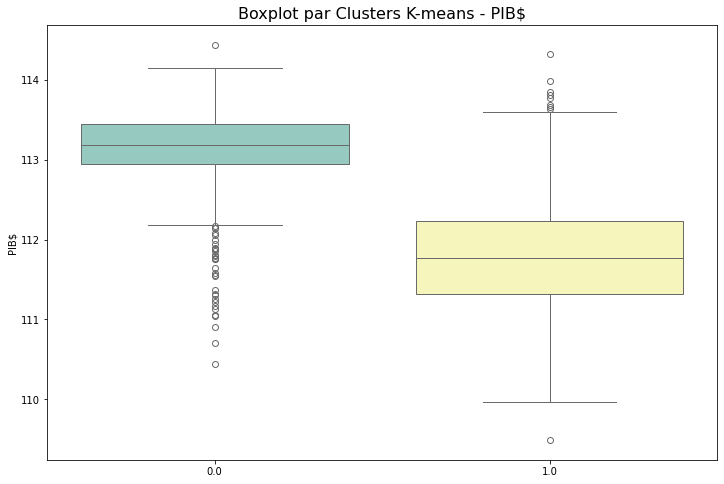

In [293]:
# Caractérisation des clusters avec des boxplots pour la variable "length"

plt.figure(figsize=(12, 8))

sns.boxplot(x='Cluster_kmeans', y='length', data=df_cleaned, palette='Set3')
plt.xlabel('')
plt.ylabel('PIB$')
plt.title('Boxplot par Clusters K-means - PIB$', fontsize=16)

# plt.savefig(
#      r"C:\Users\derou\OneDrive\Bureau\DATA\OPENCLASS\PROJETS\P9 - Produisez une étude de marché\Viz\boxplot PIB$ k-means.png",
# )

plt.show()